In [1]:
import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

In [2]:
import numpy as np
# import torch, torchvision
# from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings
from joblib import Parallel, delayed
from copy import deepcopy

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
date='aug1'#'aug81'#
cf_path = date+'_cifar10score.csv'
ss_path = date+'_ssv2score.csv'
tbcat_path = date+'_tb_catscore.csv'
tbtrans_path = date+'_tb_transscore.csv'
ucf_path = date+'_ucfscore.csv'

In [5]:
ss_base = [1./10, 0.19]
cf_base = [1./10, 0.37]
tbcat_base = [1./12, 0.265]
tbtrans_base = [1./12, 0.325]
# ucf_base = [1./101, 0.13]

In [6]:
# df_ss = pd.read_csv(ss_path)
df_cf = pd.read_csv(cf_path)
df_tbcat = pd.read_csv(tbcat_path)
# df_tbtrans = pd.read_csv(tbtrans_path)
# df_ucf = pd.read_csv(ucf_path)

In [9]:
def modify_df(df):
    new_df = df.drop(['Iteration'], axis=1)
    new_df = new_df.rename(columns={'category':'score'})
#     new_df = new_df.rename(columns={'transformation':'score'})
    return new_df

def get_stuff(code):
    if code=='tbc':
        return 'ToyBox', df_tbcat, tbcat_base
    elif code=='ucf':
        return 'UCF101', df_ucf, ucf_base
    elif code=='ss':
        return 'SSv2', df_ss, ss_base
    elif code=='cf':
        return 'CIFAR10', df_cf, cf_base

In [19]:
code = 'tbc'
title, data, baseline = get_stuff(code)
data = modify_df(data)

In [20]:
import matplotlib.pyplot as plt

# Matplotlib RC parameters for 2x2 figure layout
params = {
    'figure.figsize': (12, 6),        # Figure size (width, height) in inches
    'axes.titlesize': 12,             # Title font size
    'axes.labelsize': 10,             # Axis label font size
    'legend.fontsize': 10,            # Legend font size
    'xtick.labelsize': 20,            # X-axis tick label font size
    'ytick.labelsize': 20,            # Y-axis tick label font size
    'axes.grid': True,                # Show gridlines
    'axes.grid.axis': 'y',                # Show gridlines
    'axes.grid.which': 'both',        # Both major and minor gridlines
    'grid.linestyle': '--',           # Gridlines style
    'grid.alpha': 0.9,                # Gridlines transparency
    'lines.linewidth': 2.0,           # Line width
    'lines.markersize': 7.0,          # Marker size
    'savefig.dpi': 300,               # Resolution for saved figures
    'savefig.transparent': True,      # Transparent background when saving figures
    'axes.linewidth': 1.,            # Spine linewidth
    'axes.edgecolor': 'black',
}

plt.rcParams.update(params)


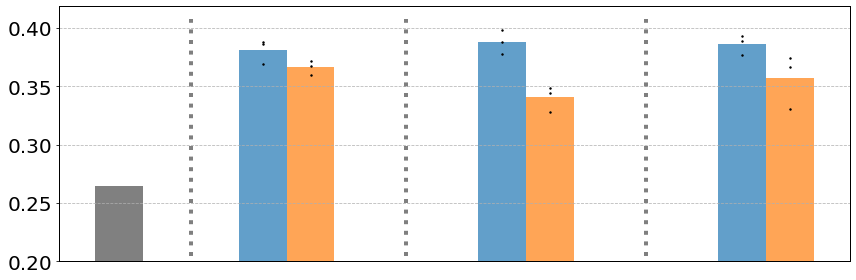

In [21]:
# Assuming your DataFrame is named "data"
fig, ax = plt.subplots(figsize=(12, 4))

# Define custom colors for dev and adev curricula
colors = {"dev": "tab:blue", "adev": "tab:orange"}

# Define custom saturation levels for conditions
saturation = {
    "default": 0.7,
    "MatchedSpatial": 0.5,
    "MatchedTemporal": 0.7,
    "MatchedSpatioTemporal": 0.9
}

stages = [1,2,3]
conditions = ['default']#, 'MatchedSpatial', 'MatchedTemporal', 'MatchedSpatioTemporal']
curricula = ['dev', 'adev']

# Set the distances between bars and the bar width
sto = 0.1 #stage offset
coo = 0.02 # condition offset
cuo = 0.02 # curriculum offset
bar_width = 0.02

# Group data by Stage and Curriculum
# grouped_data = data.groupby(['Stage', 'Curriculum'])

# Set the width of each bar

def get_rows(df, stage, cond, curr):
    selected_rows = df[(df['Stage'] == stage) & (df['Condition'] == cond) & (df['Curriculum'] == curr)]
    mean = selected_rows['score'].mean()
    sd = selected_rows['score'].std()
    return mean, sd, selected_rows['score']

ax.bar(0, baseline[1], width= bar_width, color='gray', label='untrained')
# Iterate through each Stage and Curriculum to plot the bars
# for i, ((stage, curriculum), group) in enumerate(grouped_data):
for i_st, stage in enumerate(stages):
    for i_cond, cond in enumerate(conditions):
        for i_curr, curr in enumerate(curricula):
            x_offset = 3*bar_width+ i_st*sto+i_cond*coo+i_curr*cuo
            label=f"{curr}-{cond}"
            if stage!=1:
                label = '_'+label
            
            score_mean, score_sd, y_scatter = get_rows(data, stage, cond, curr)
            x_scatter = [x_offset 
                         for i in y_scatter]
        
            ax.bar(
                x_offset,
                score_mean,
                width=bar_width,
                color=colors[curr],
                alpha=saturation[cond],  # You can adjust the alpha value to control the transparency of bars
                label=label,
            )
            ax.scatter(x_scatter, y_scatter, c='k', s=2)

ymin = 0.2#baseline[0]
ymax = data['score'].max()
yrange = ymax-ymin
ax.set_ylim([ymin, ymax+yrange*0.1])

x_vlines = [bar_width*1.5, 
           bar_width*2 +sto*1-1*coo,
           bar_width*2 +sto*2-1*coo]
for i in range(3):
#     x_vline = bar_width*1.5 +sto*i
    ax.axvline(x_vlines[i], ymin=0.02, ymax=0.95, color='k', linestyle='dotted', alpha=0.5, linewidth=4)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

ax.yaxis.set_major_locator(plt.MultipleLocator(0.05))

# matplotlib.spines.Spines().alpha=0.1
# plt.ylabel('Linear Evaluation Score')
# plt.title(title)
# plt.legend(title="Curriculum - Condition", loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()

plt.savefig('jepa_'+title+'.pdf', dpi=300)
plt.savefig('jepa_'+title+'.png', dpi=300)